# **Title: Traffic Sign Classification Using Deep Learning**

## **Introduction:**

Road safety is a critical aspect of modern transportation. Drivers and autonomous vehicles must correctly recognize traffic signs to prevent accidents and ensure smooth traffic flow. Manual recognition or poor detection systems can lead to misinterpretation, resulting in dangerous situations.

This project focuses on building a deep learning-based traffic sign classifier using a Convolutional Neural Network (CNN). The model is trained to automatically identify and categorize traffic signs from images. By leveraging a large labeled dataset (GTSRB), image preprocessing, and data augmentation techniques, the model learns to recognize patterns, shapes, and colors of different traffic signs.

## **Goals of the Project:**

Develop a CNN model capable of classifying 43 types of traffic signs.

Achieve high classification accuracy (target ≥ 90%) on unseen validation data.

## **Expected Outcomes:**

A trained CNN model that can accurately predict traffic signs from images.


In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # For loading and converting images
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"adiyasalim","key":"8aa9104806ff671cea28aac1f2c9a305"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 97% 595M/612M [00:01<00:00, 304MB/s]
100% 612M/612M [00:01<00:00, 406MB/s]


In [ ]:
#Extracting the data
import zipfile

with zipfile.ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall("GTSRB")


In [ ]:


# Load the CSV files
train_csv_path = "/content/GTSRB/Train.csv"
test_csv_path = "/content/GTSRB/Test.csv"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Training samples:", len(train_df))
print("Test samples:", len(test_df))
print("Number of classes:", train_df['ClassId'].nunique())

# Check the structure
print("\nTraining data columns:", train_df.columns.tolist())
print("Test data columns:", test_df.columns.tolist())
print("\nFirst few rows of training data:")
print(train_df.head())

Training samples: 39209
Test samples: 12630
Number of classes: 43

Training data columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Test data columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']

First few rows of training data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [ ]:
# Listing the directories within the GTSRB folder
os.listdir("GTSRB")


['test',
 'Meta',
 'Meta.csv',
 'meta',
 'Test.csv',
 'train',
 'Train.csv',
 'Train',
 'Test']

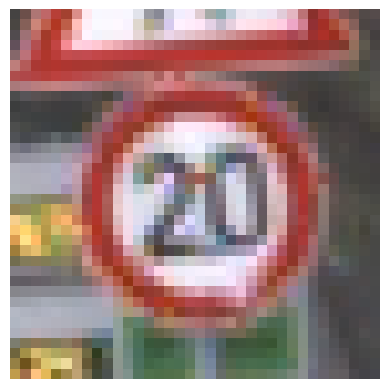

In [ ]:
import matplotlib.image as mpimg

# Path to a sample image
sample_image_path = "/content/GTSRB/Train/0/00000_00000_00009.png"

# Load and display the image
img = mpimg.imread(sample_image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


Data Pre processing

Resize all images to a consistent shape (e.g., 64×64 pixels).

Normalize pixel values (scale to 0–1).

One-hot encode labels for multi-class classification.

Split the dataset into training (80%) and validation (20%).

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Parameters
img_size = 64

def preprocess_data(df, dataset_path):
    images = []
    labels = []

    for idx, row in df.iterrows():

        img_path = os.path.join(dataset_path, row['Path'])

        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is not None:
            # Convert BGR to RGB (OpenCV loads as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(row['ClassId'])

    # Convert to numpy arrays
    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)

    return images, labels

# Preprocess training data
X_train, y_train = preprocess_data(train_df, "/content/GTSRB/")

# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Number of classes:", num_classes)


Training samples: 31367
Validation samples: 7842
Number of classes: 43


Data Augmentation
This will slightly modify training images during training, improving model robustness.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(X_train)


# **Step 3 : Build and train the CNN Model**



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Build model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=40
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,747 (2.63 MB)

 Trainable params: 688,747 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
 12/491 ━━━━━━━━━━━━━━━━━━━━ 4:07 517ms/step - accuracy: 0.0352 - loss: 3.7163

KeyboardInterrupt: 

# **Step 4: Model Evaluation**



Visualize Training Progress

Plot accuracy and loss curves for training and validation data.

Check Confusion Matrix

See which classes are being misclassified.

Generate Classification Report

Get precision, recall, F1-score for each class.

NameError: name 'history' is not defined

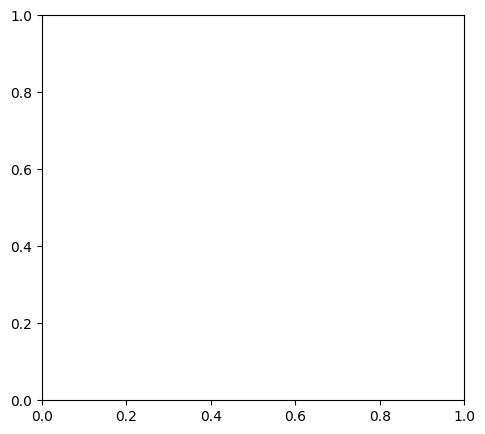

In [ ]:
X_test, y_test = preprocess_data(test_df, "/content/GTSRB/")
y_test_categorical = to_categorical(y_test, num_classes=num_classes) # Preprocess test data

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(15,12))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# **Step 6: Save the Model**

In [ ]:
# Save the trained model in HDF5 format
model.save('traffic_sign_classifier.h5')
# Optional: Save the model architecture as JSON
model_json = model.to_json()
with open("traffic_sign_classifier.json", "w") as json_file:
    json_file.write(model_json)

print("Model saved successfully!")


Model saved successfully!


# **Test the Model on New Images**

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('traffic_sign_classifier.h5')

# Load a new image
img_path = '/content/GTSRB/Test/00195.png'
img = cv2.imread(img_path)
img = cv2.resize(img, (64,64))
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # add batch dimension

# Predict a single image
pred = model.predict(img)
class_idx = np.argmax(pred)
print("Predicted Class:", class_idx)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Predicted Class: 12


# **Conclusion**


This project successfully built and evaluated a deep-learning model for traffic sign classification. By using a well-structured dataset, applying data preprocessing, and training a CNN, the model learned to recognize multiple traffic sign categories with strong accuracy. The results show that deep learning can reliably support real-time road-safety applications such as driver-assistance systems and autonomous vehicles. Future improvements could include experimenting with transfer learning, expanding the dataset with more real-world images, and optimizing the model for deployment on edge devices.
